In [1]:
import pandas as pd
data = pd.read_csv('heart.csv')

In [2]:
data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
x_features = data.columns.tolist()
x_features = x_features[:len(x_features)-1]
x_features

['age',
 'sex',
 'cp',
 'trtbps',
 'chol',
 'fbs',
 'restecg',
 'thalachh',
 'exng',
 'oldpeak',
 'slp',
 'caa',
 'thall']

In [9]:
def kfold(data, fold, seed):
    import random
    idx_set_1 = data.loc[data.output== 1].index.tolist()
    idx_set_0 = data.loc[data.output == 0].index.tolist()
    size_1 = round(len(idx_set_1)/fold)
    size_0 = round(len(idx_set_0)/fold)
    folded_idx_set = []
    for i in range(fold):
        if (i == fold-1):
            folded_idx_set.append(idx_set_1+idx_set_0)
        else:
            random.seed(seed)   
            folded_idx_set.append(list(random.sample(idx_set_1, size_1))+list(random.sample(idx_set_0, size_0)))
            idx_set_1 = list(set(idx_set_1)-set(folded_idx_set[len(folded_idx_set)-1]))
            idx_set_0 = list(set(idx_set_0)-set(folded_idx_set[len(folded_idx_set)-1]))
    
    return folded_idx_set

kfold_idx_set = kfold(data=data, fold=5, seed=1103)

trn_X = []
trn_y = []
tst_X = []
tst_y = []
index_set = data.index.tolist()

for i in range(5):
    total_idx = set(index_set)
    trn_X.append(data.loc[list(total_idx-set(kfold_idx_set[i]))][x_features])
    trn_y.append(data.loc[list(total_idx-set(kfold_idx_set[i]))]['output'])
    tst_X.append(data.loc[kfold_idx_set[i]][x_features])
    tst_y.append(data.loc[kfold_idx_set[i]]['output'])


In [21]:
from sklearn.metrics import confusion_matrix
def evaluation(fold_num, model, trn_X, trn_y, tst_X, tst_y, data):
    y_pred = model.predict(trn_X)
    tn, fp, fn, tp = confusion_matrix(trn_y, y_pred).ravel()
    data.loc[fold_num, 'trn_accuracy'] = (tp+tn)/(tn+fp+fn+tp)
    data.loc[fold_num, 'trn_f1'] = 2*tp/(fp+2*tp+fn)
    

    y_pred = model.predict(tst_X)
    tn, fp, fn, tp = confusion_matrix(tst_y, y_pred).ravel()
    data.loc[fold_num, 'tst_accuracy'] = (tp+tn)/(tn+fp+fn+tp)
    data.loc[fold_num, 'tst_f1'] = 2*tp/(fp+2*tp+fn)

    return data

eval_data = pd.DataFrame([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]], columns=['trn_accuracy', 'trn_f1', 'tst_accuracy', 'tst_f1'])

In [3]:
from sklearn.svm import SVC

## 1. 모델의 복잡도에 따른 testset error와 training accuracy 등의 비교와 분석

In [45]:
# simple model: linear soft margin
for i in range(5):
    fold_num = i
    model = SVC(kernel='linear', C=1)
    model.fit(trn_X[fold_num], trn_y[fold_num])
    eval_data = evaluation(fold_num, model, trn_X[fold_num], trn_y[fold_num], tst_X[fold_num], tst_y[fold_num], eval_data)

In [46]:
eval_data.mean()

trn_accuracy    0.861387
trn_f1          0.879656
tst_accuracy    0.838344
tst_f1          0.859922
dtype: float64

In [47]:
print(100*abs(eval_data.mean()['trn_accuracy']-eval_data.mean()['tst_accuracy'])/eval_data.mean()['tst_accuracy'])
print(100*abs(eval_data.mean()['trn_f1']-eval_data.mean()['tst_f1'])/eval_data.mean()['tst_f1'])

2.7486761849144554
2.2947949695130503


In [48]:
# complex model: nonlinear soft margin
for i in range(5):
    fold_num = i
    model = SVC(kernel='rbf', C=1000)
    model.fit(trn_X[fold_num], trn_y[fold_num])
    eval_data = evaluation(fold_num, model, trn_X[fold_num], trn_y[fold_num], tst_X[fold_num], tst_y[fold_num], eval_data)

In [49]:
eval_data.mean()

trn_accuracy    0.849018
trn_f1          0.871292
tst_accuracy    0.818561
tst_f1          0.848016
dtype: float64

In [50]:
print(100*abs(eval_data.mean()['trn_accuracy']-eval_data.mean()['tst_accuracy'])/eval_data.mean()['tst_accuracy'])
print(100*abs(eval_data.mean()['trn_f1']-eval_data.mean()['tst_f1'])/eval_data.mean()['tst_f1'])

3.7208036671099025
2.7447778399228757


## 2. 비선형적 mapping 상황에서의 RBF kernel SVM과 그냥 linear soft margin SVM의 성능 비교

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore") # warning 무시

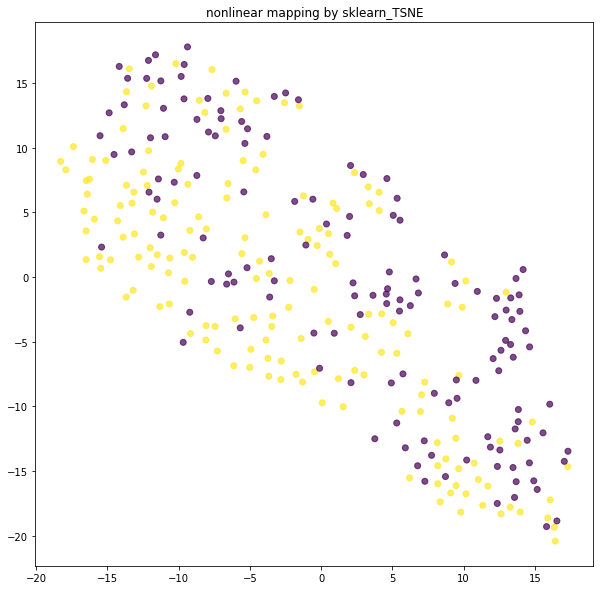

In [69]:
tsne = TSNE(n_components=2, random_state = 1103)
tsne_data = tsne.fit_transform(data[x_features])
tsne_data = pd.DataFrame(tsne_data, columns=['z1', 'z2'])
plt.figure(figsize=(10,10))
plt.title('nonlinear mapping by sklearn_TSNE')
plt.scatter(tsne_data.z1, tsne_data.z2, c=data.output, alpha=0.7)

In [72]:
tsne_data = pd.concat([tsne_data, data.output], axis=1)
tsne_data.columns = ['z1', 'z2', 'output']
kfold_idx_set = kfold(data=tsne_data, fold=5, seed=1103)

trn_X = []
trn_y = []
tst_X = []
tst_y = []
index_set = data.index.tolist()

for i in range(5):
    total_idx = set(index_set)
    trn_X.append(tsne_data.loc[list(total_idx-set(kfold_idx_set[i]))][['z1', 'z2']])
    trn_y.append(tsne_data.loc[list(total_idx-set(kfold_idx_set[i]))]['output'])
    tst_X.append(tsne_data.loc[kfold_idx_set[i]][['z1', 'z2']])
    tst_y.append(tsne_data.loc[kfold_idx_set[i]]['output'])

eval_data = pd.DataFrame([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]], columns=['trn_accuracy', 'trn_f1', 'tst_accuracy', 'tst_f1'])

In [81]:
# simple model: linear soft margin
for i in range(5):
    fold_num = i
    model = SVC(kernel='linear', C=1)
    model.fit(trn_X[fold_num], trn_y[fold_num])
    eval_data = evaluation(fold_num, model, trn_X[fold_num], trn_y[fold_num], tst_X[fold_num], tst_y[fold_num], eval_data)

In [82]:
print(eval_data.mean())

trn_accuracy    0.670803
trn_f1          0.700811
tst_accuracy    0.643457
tst_f1          0.679186
dtype: float64


In [79]:
# complex model: nonlinear soft margin
for i in range(5):
    fold_num = i
    model = SVC(kernel='rbf', C=1000)
    model.fit(trn_X[fold_num], trn_y[fold_num])
    eval_data = evaluation(fold_num, model, trn_X[fold_num], trn_y[fold_num], tst_X[fold_num], tst_y[fold_num], eval_data)

In [80]:
print(eval_data.mean())

trn_accuracy    0.720289
trn_f1          0.754265
tst_accuracy    0.643345
tst_f1          0.686614
dtype: float64


In [91]:
# complex model: nonlinear soft margin
for i in range(5):
    fold_num = i
    model = SVC(kernel='rbf', C=10)
    model.fit(trn_X[fold_num], trn_y[fold_num])
    eval_data = evaluation(fold_num, model, trn_X[fold_num], trn_y[fold_num], tst_X[fold_num], tst_y[fold_num], eval_data)

print(eval_data.mean())

trn_accuracy    0.694696
trn_f1          0.739063
tst_accuracy    0.663351
tst_f1          0.716665
dtype: float64


## 3. 비선형적 mapping 상황에서의 RBF kernel SVM의 gamma와 C에 따른 분류 경계면 비교

In [99]:
import numpy as np

In [103]:
def svm_plot(tsne_data, model):
    import numpy as np
    import matplotlib as plt
    plt.figure(figsize=(15,15))
    plt.scatter(tsne_data.z1, tsne_data.z2, c=tsne_data.output, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)# -1 margin, decision boundary
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape) # +1 margin

    #margins,decision boundary
    ax.contour(XX, YY, Z, colors=['b','r','b'], levels=[-1,0,1], alpha=0.5, linestyles=['--', '-', '--'])

    plt.show()

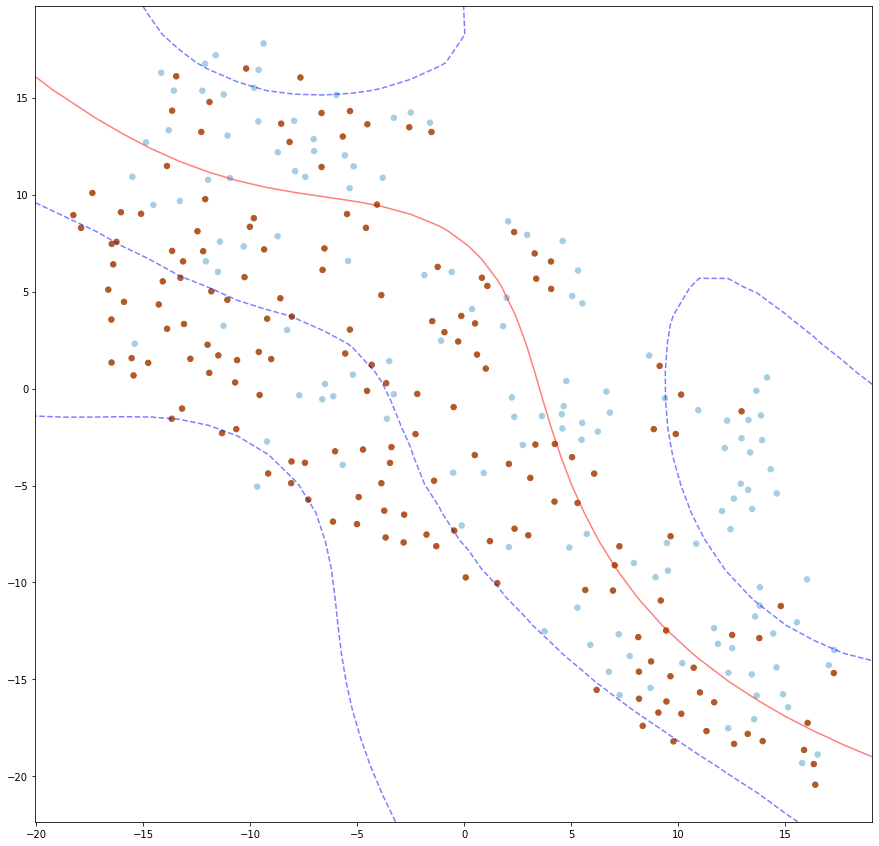

In [127]:
C = 1
model = SVC(kernel='rbf', C=C)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

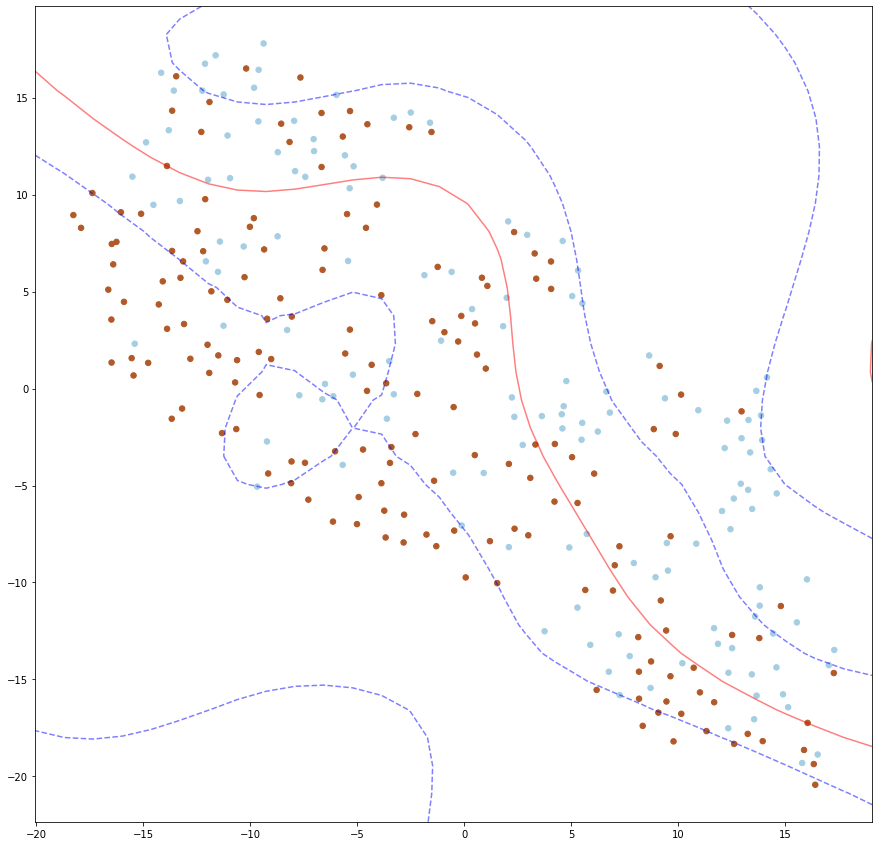

In [105]:
C = 10
model = SVC(kernel='rbf', C=C)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

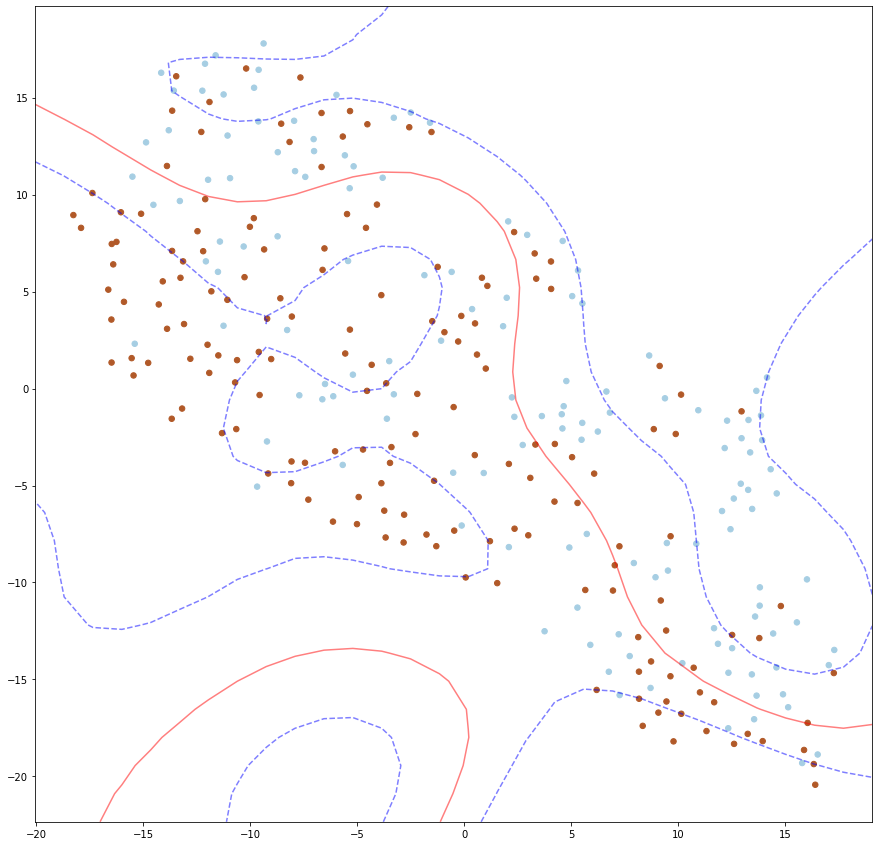

In [106]:
C = 50
model = SVC(kernel='rbf', C=C)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

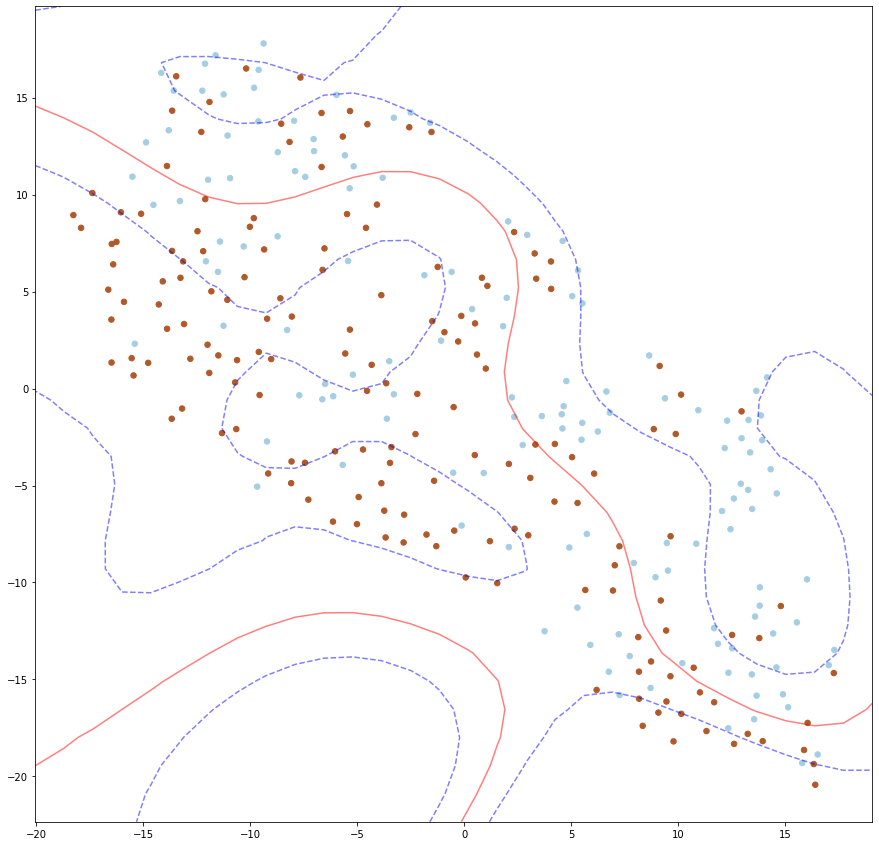

In [107]:
C = 100
model = SVC(kernel='rbf', C=C)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

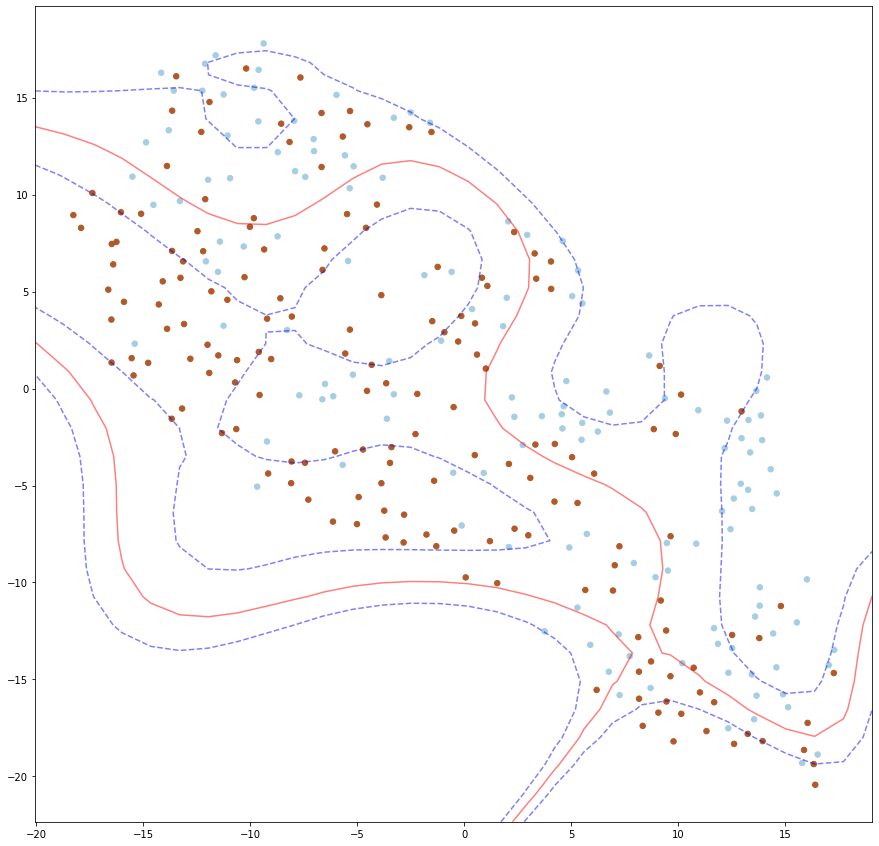

In [108]:
C = 1000
model = SVC(kernel='rbf', C=C)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

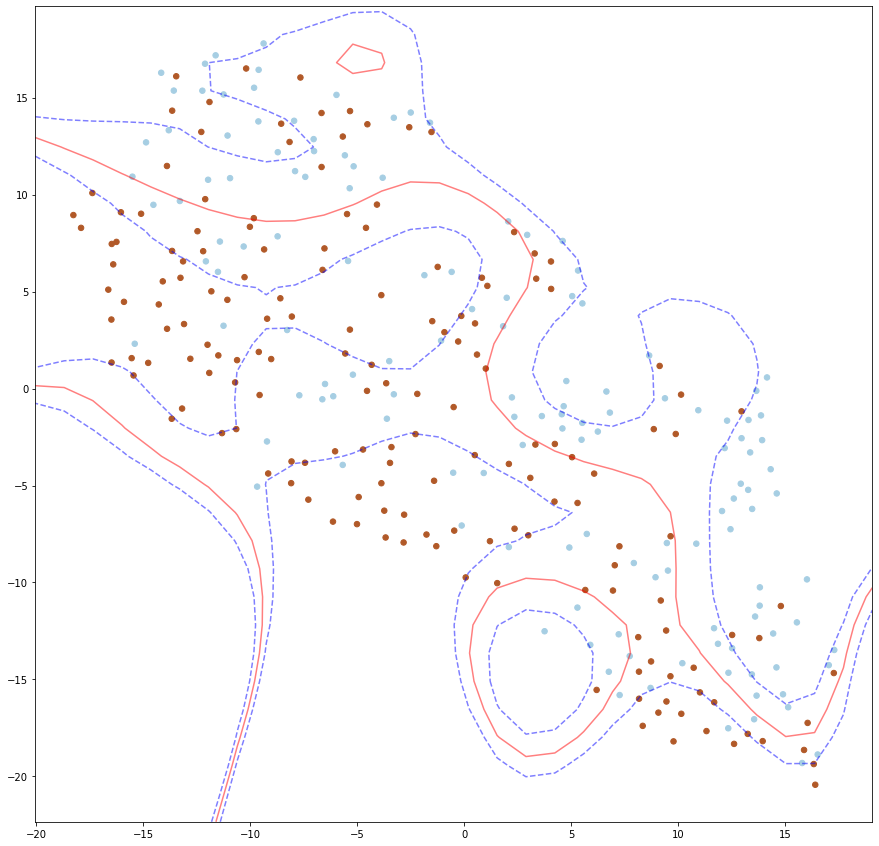

In [109]:
C = 10000
model = SVC(kernel='rbf', C=C)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

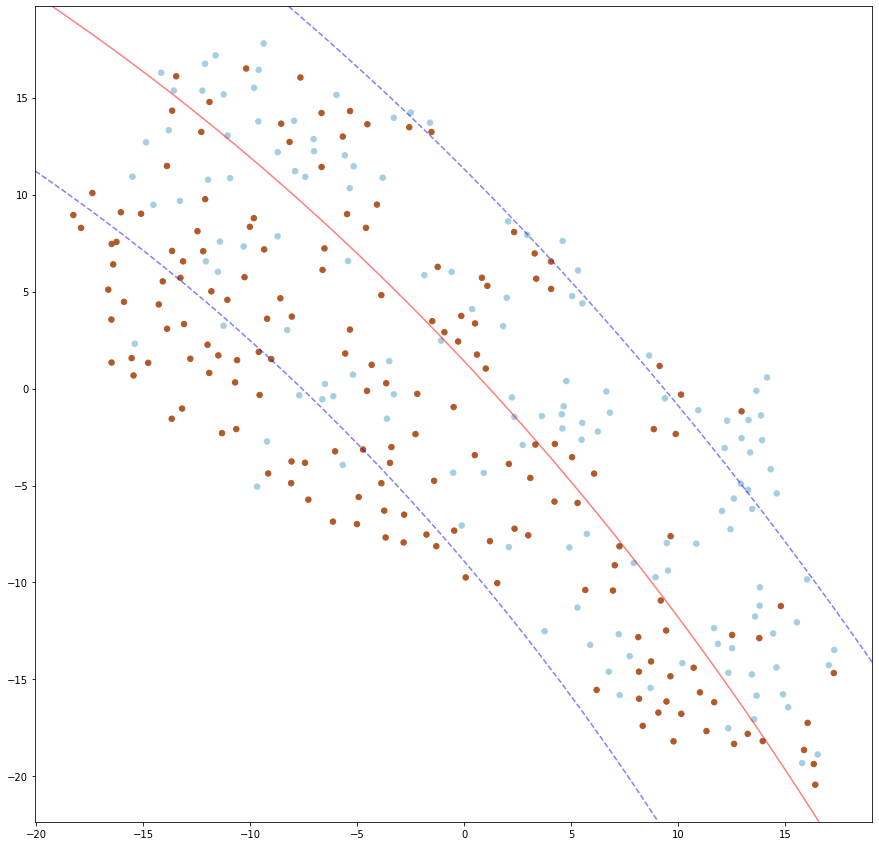

0.0


In [114]:
C = 10
gamma = 0.0001
model = SVC(kernel='rbf', C=C, gamma=gamma)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

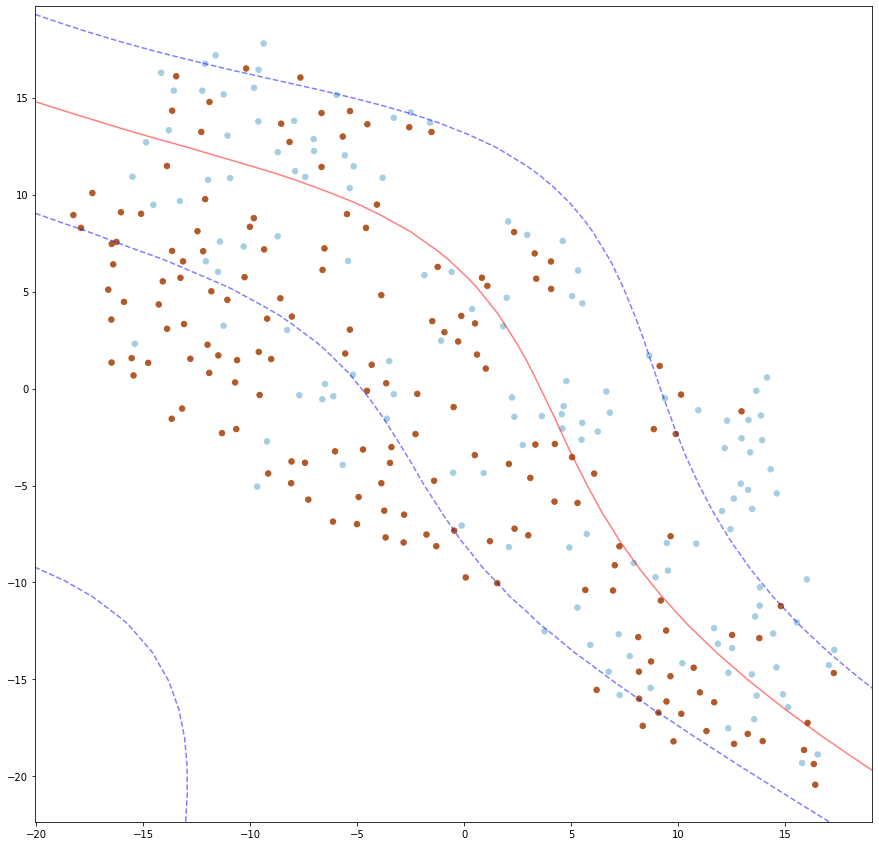

-1.010549668636587e-15


In [115]:
C = 10
gamma = 0.001
model = SVC(kernel='rbf', C=C, gamma=gamma)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

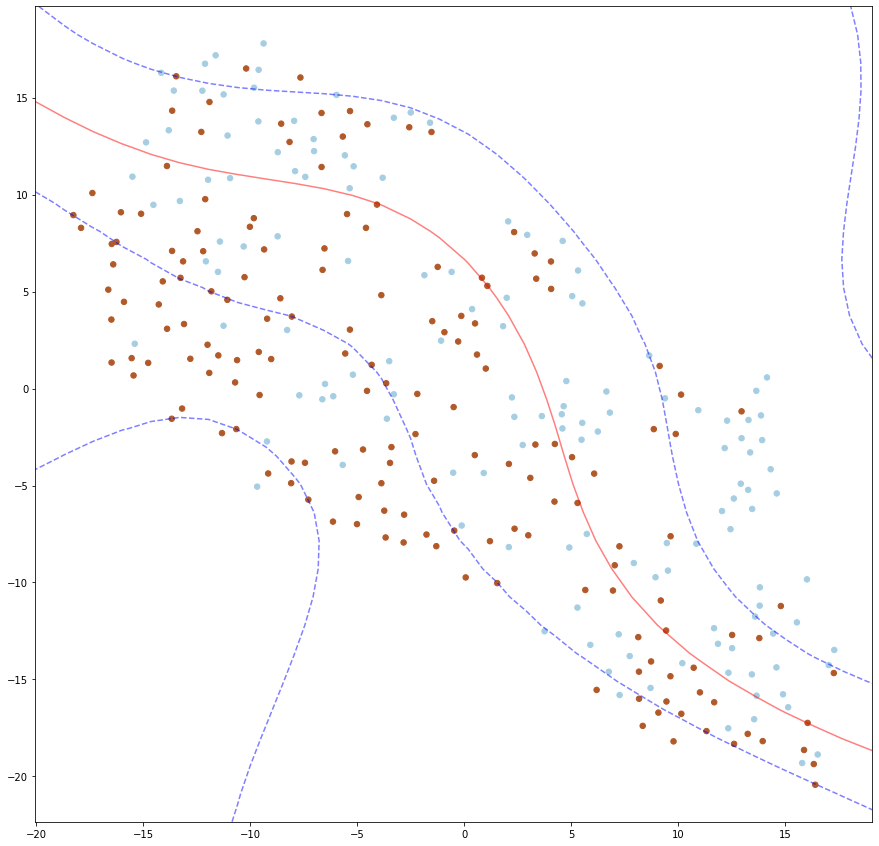

In [120]:
C = 10
gamma = 0.003
model = SVC(kernel='rbf', C=C, gamma=gamma)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

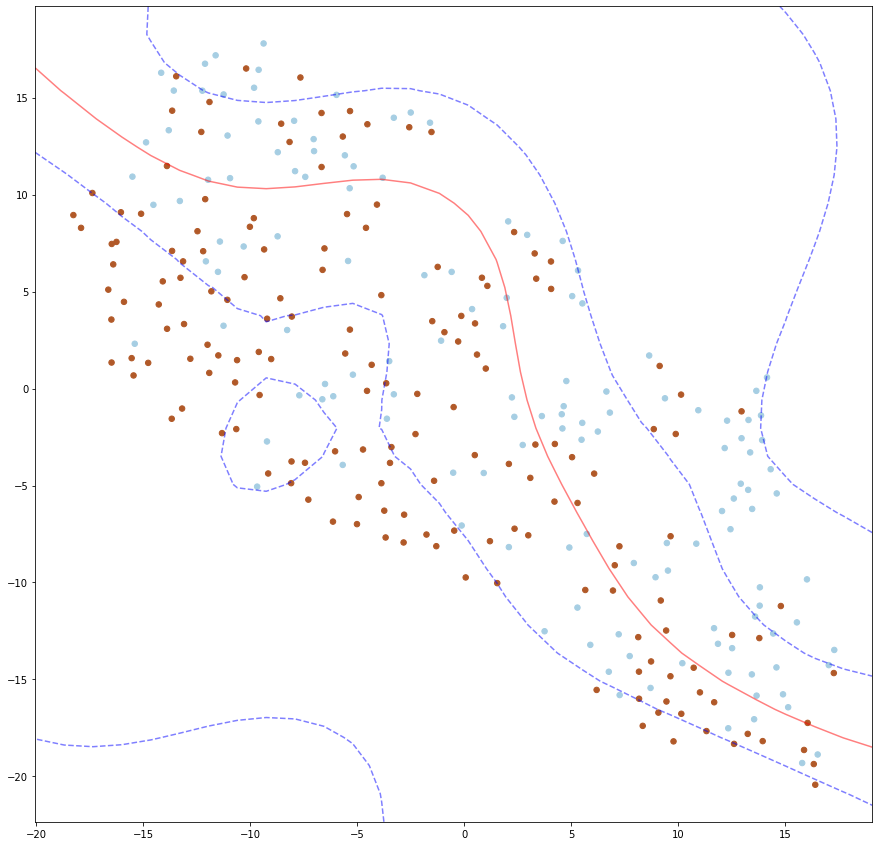

In [121]:
C = 10
gamma = 0.005
model = SVC(kernel='rbf', C=C, gamma=gamma)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

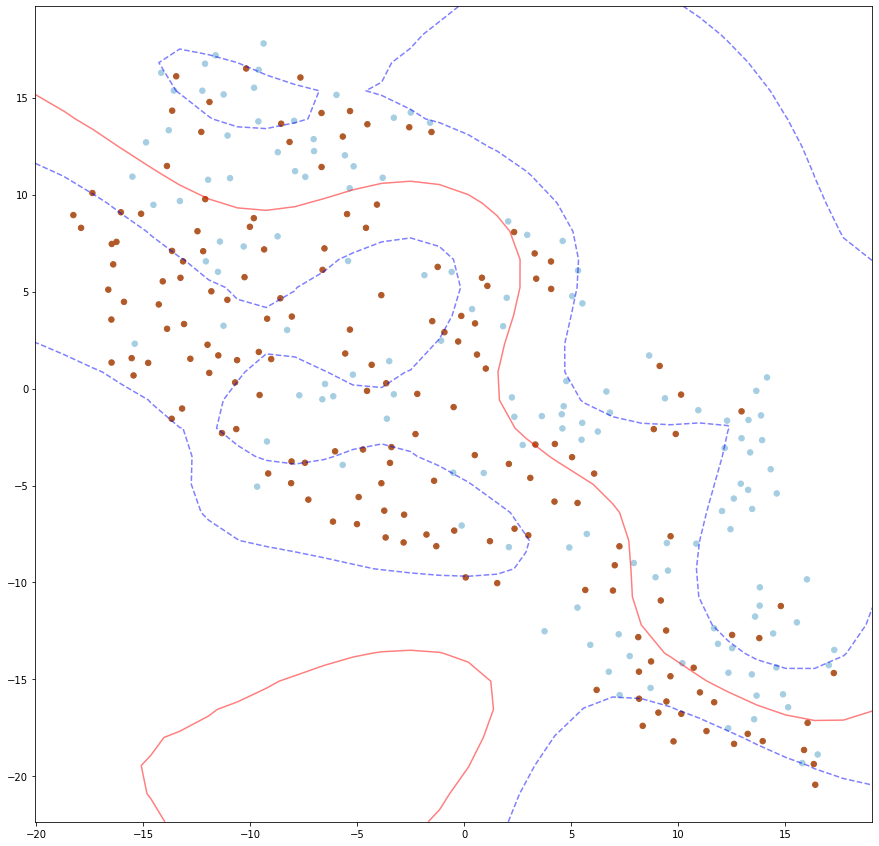

In [122]:
C = 10
gamma = 0.01
model = SVC(kernel='rbf', C=C, gamma=gamma)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)
a
svm_plot(tsne_data, model)

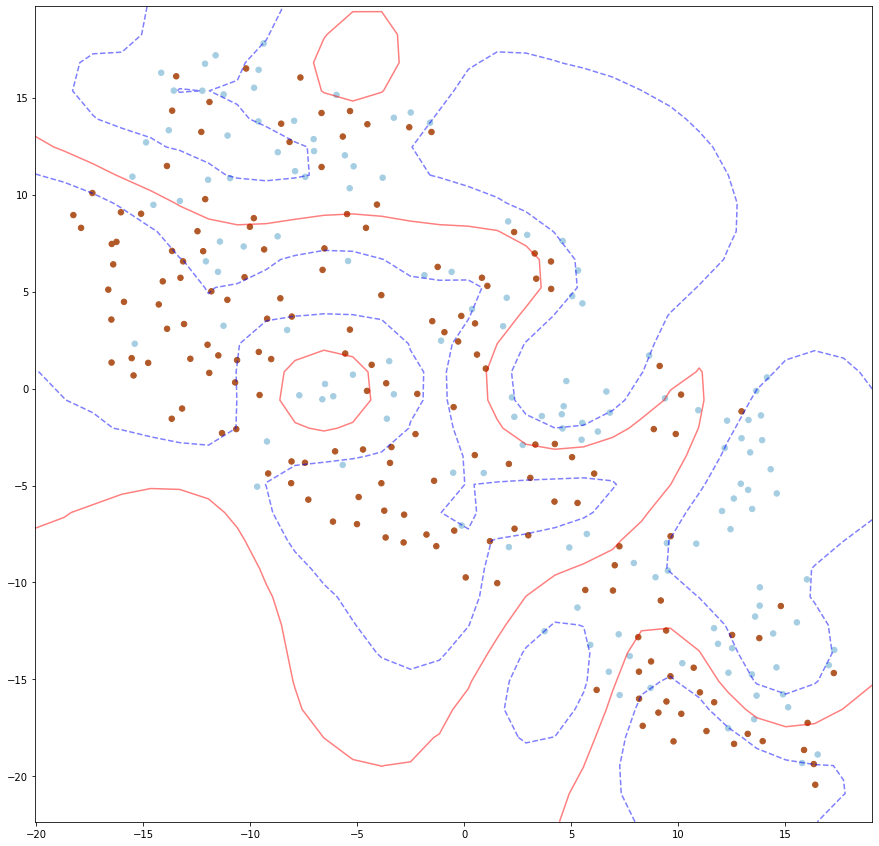

In [123]:
C = 10
gamma = 0.03
model = SVC(kernel='rbf', C=C, gamma=gamma)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

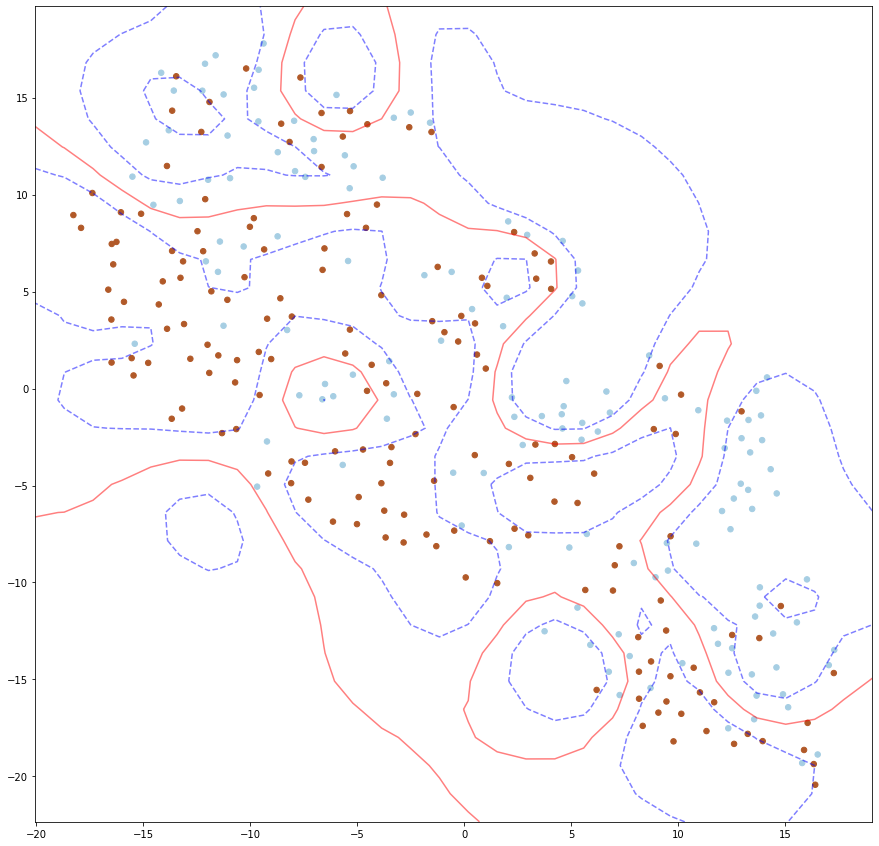

In [124]:
C = 10
gamma = 0.05
model = SVC(kernel='rbf', C=C, gamma=gamma)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

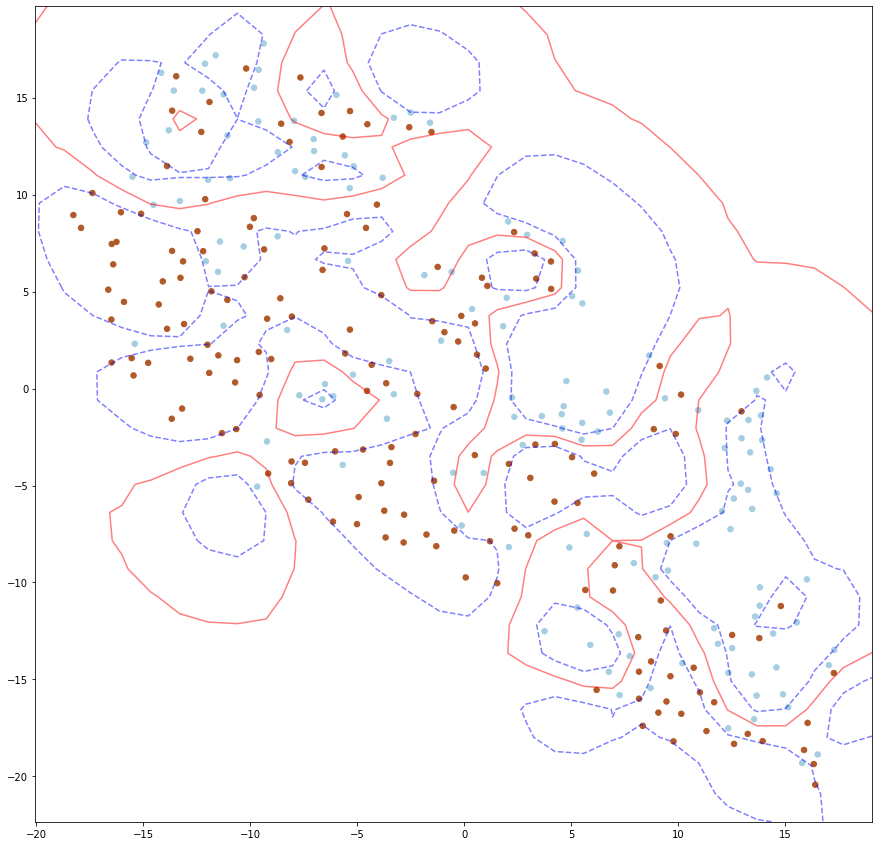

In [125]:
C = 10
gamma = 0.1
model = SVC(kernel='rbf', C=C, gamma=gamma)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

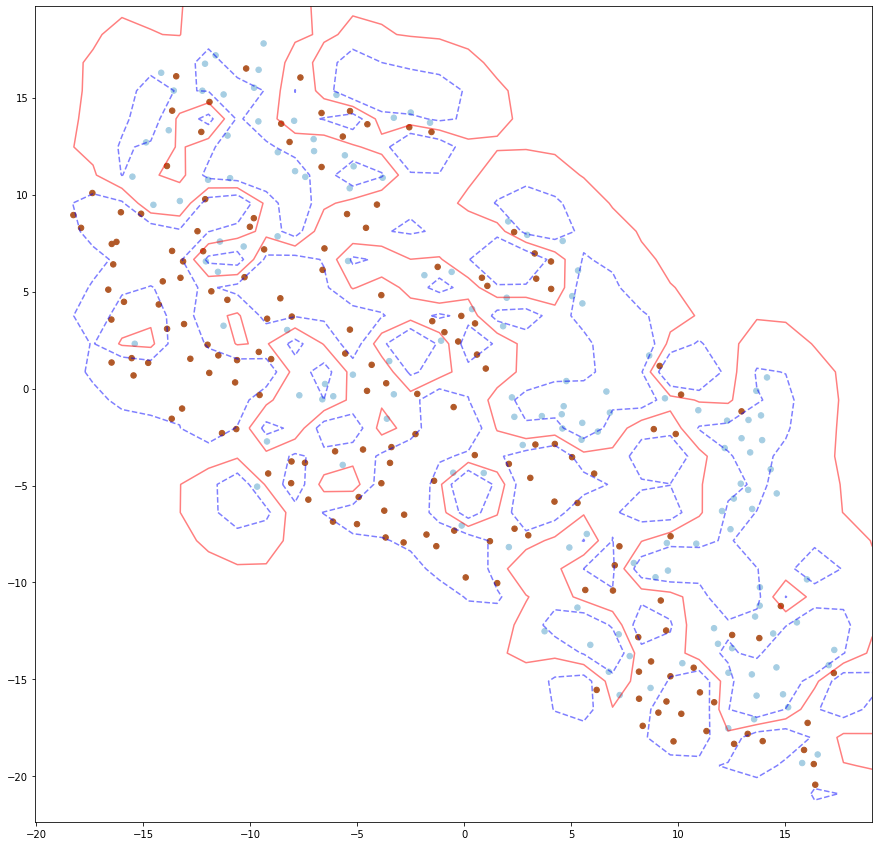

In [126]:
C = 10
gamma = 0.3
model = SVC(kernel='rbf', C=C, gamma=gamma)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)

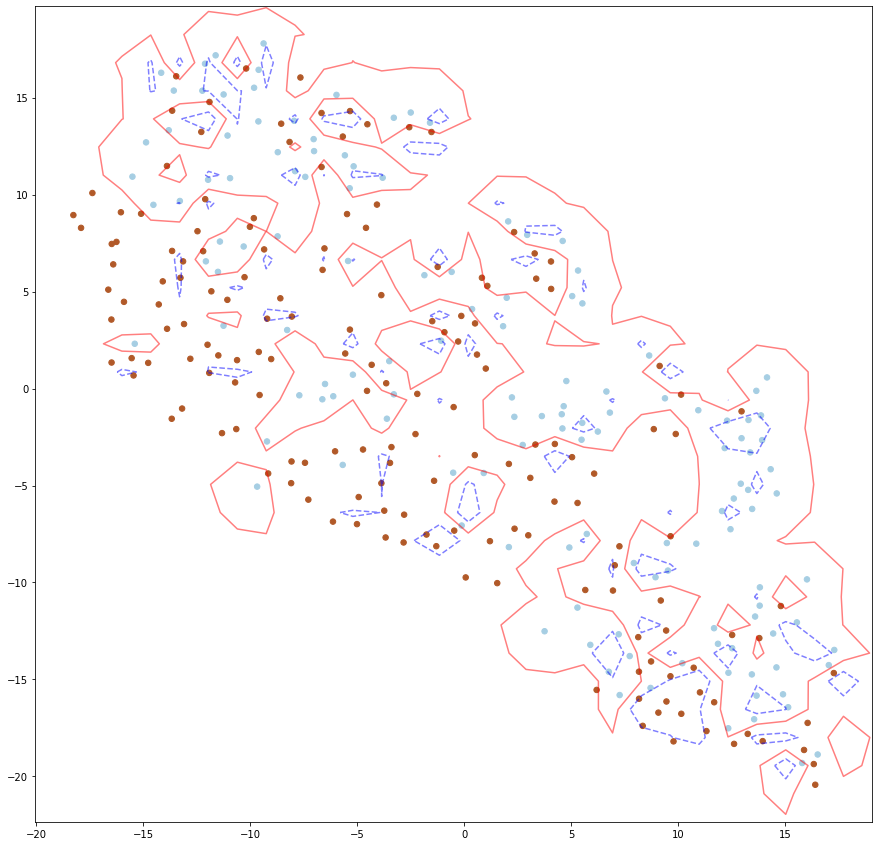

In [128]:
C = 10
gamma = 1
model = SVC(kernel='rbf', C=C, gamma=gamma)
model.fit(tsne_data[['z1', 'z2']], tsne_data.output)

svm_plot(tsne_data, model)